In [ ]:
!pip install -U spacy 

In [ ]:
!python -m spacy download en_core_web_lg

ERROR: Exception:
Traceback (most recent call last):
  File "C:\Users\Amanih\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 438, in _error_catcher
    yield
  File "C:\Users\Amanih\anaconda3\lib\site-packages\pip\_vendor\urllib3\response.py", line 519, in read
    data = self._fp.read(amt) if not fp_closed else b""
  File "C:\Users\Amanih\anaconda3\lib\site-packages\pip\_vendor\cachecontrol\filewrapper.py", line 62, in read
    data = self.__fp.read(amt)
  File "C:\Users\Amanih\anaconda3\lib\http\client.py", line 462, in read
    n = self.readinto(b)
  File "C:\Users\Amanih\anaconda3\lib\http\client.py", line 506, in readinto
    n = self.fp.readinto(b)
  File "C:\Users\Amanih\anaconda3\lib\socket.py", line 704, in readinto
    return self._sock.recv_into(b)
  File "C:\Users\Amanih\anaconda3\lib\ssl.py", line 1241, in recv_into
    return self.read(nbytes, buffer)
  File "C:\Users\Amanih\anaconda3\lib\ssl.py", line 1099, in read
    return self._sslobj.read(len, buf

In [ ]:
# Main libraries 
import pandas as pd
import numpy as np

# Preprocessing
#!pip install gensim # i think it is already there in colab
import gensim
from gensim.utils import simple_preprocess 
import re

import matplotlib.pyplot as plt
%matplotlib inline

#to increase the space of displaying texts
pd.options.display.max_colwidth = 200 

Load extracted submissions and comments 

In [ ]:
# use this as many Comments files you have, just change the dataframe number and file name 
cdf= pd.read_csv('comments_ve2y.csv', encoding = "utf-8", on_bad_lines='skip') 
cdf1= pd.read_csv('comments_ca1y.csv', encoding = "utf-8", on_bad_lines='skip') 

In [ ]:
cdf_ve = cdf[cdf['created_utc']> 1606780799].copy() # selecting comments after 1/12/2020 [as I have some older data in my file]
print(cdf_ve.shape)

(511071, 9)


In [ ]:
# Combine all Comments dataframes in one dataframe 
cdf_master = cdf_ve.append([cdf1], ignore_index= True)  #ignore_index= True

In [ ]:
# use this as many Submissions files you have, just change the dataframe number and file name 
sdf= pd.read_csv('submissions_ve1y.csv', encoding = "utf-8", on_bad_lines='skip'); 
sdf1= pd.read_csv('submissions_ca1y.csv', encoding = "utf-8", on_bad_lines='skip'); 

In [ ]:
# Combine all Submissions dataframes in one dataframe 
sdf_master = sdf.append([sdf1], ignore_index = True)  

In [ ]:
#check number of submissions and comments 
print('Total number of submissions' + " " + str(len(sdf_master)))
print('Total number of comments' + " " + str(len(cdf_master)))

Total number of submissions 21030
Total number of comments 514002


Deal with removed/deleted submissions and comments 

In [ ]:
#noticed that some "removed" submissions have some text beside the word "removed", so this code is to process that.
sdf_master['selftext'] = sdf_master['selftext'].replace(r"\[removed\].*", value='[removed]', regex=True).copy()

In [ ]:
#Count the number of deleted or removed submissions/comments from the corpus 
print(len(sdf_master[(sdf_master['selftext'] == '[removed]') | (sdf_master['selftext'] == '[deleted]')] ))
print(len(cdf_master[(cdf_master['body'] == '[removed]') | (cdf_master['body'] == '[deleted]')] ))

1563
10675


In [ ]:
#Count the number of deleted or removed submissions which has no comments from the corpus 
print(len((sdf_master[(((sdf_master['selftext'] == '[removed]') | (sdf_master['selftext'] == '[deleted]')) & (sdf_master['num_comments'] == 0))== True])))

#Count the number of deleted or removed comments from the corpus 
print(len(cdf_master[(cdf_master['body'] == '[removed]') | (cdf_master['body'] == '[deleted]')] ))

768
10675


In [ ]:
# Remove deleted and removed comments/submissions
sdf_master_clean = sdf_master.loc[(((sdf_master['selftext'] == '[removed]') | (sdf_master['selftext'] == '[deleted]')) & (sdf_master['num_comments'] == 0))== False].copy()
print('Total number of submissions = ', len(sdf_master_clean))

cdf_master_clean = cdf_master.loc[(cdf_master['body'] != '[removed]') & (cdf_master['body'] != '[deleted]')].copy()
print('Total number of comments = ', len(cdf_master_clean))
#for .copy, check https://www.dataquest.io/blog/settingwithcopywarning/ (I used .loc, but it wasn't enough , .copy solved the issue, it seems it is hidden chain)


Total number of submissions =  20262
Total number of comments =  503327


In [ ]:
sdf_master_clean["selftext"].replace(r'\[removed\]', " ", regex=True, inplace=True)
sdf_master_clean["selftext"].replace(r'\[deleted\].*', " ", regex=True, inplace=True)
#second answer : https://stackoverflow.com/questions/37593550/replace-method-not-working-on-pandas-dataframe

Append Submissions and Comments  

In [ ]:
# Note that both submission's title and text are considered becuase there are a lot of submissions having titles without text.
sdf_master_clean['combined_text'] = sdf_master_clean["title"].astype(str) + ". " + sdf_master_clean["selftext"].astype(str)


In [ ]:
#Extract the text of comments/submissions and combine them, calling them posts this point forward
posts_texts = sdf_master_clean['combined_text'].append(cdf_master_clean['body'])
print('Total number of posts = ', len(posts_texts))


Total number of posts =  523589


In [ ]:
#to handle emoji encoding, as vader recognizes emojies 
posts_texts = posts_texts.str.encode('latin', errors= 'ignore').str.decode('utf-8', errors= 'ignore')

Documents' test Preprocessing 

In [ ]:
#'nan' and newline charachter removal 

posts_texts = posts_texts.replace(r'\.+', ".", regex=True) # replace multiple dots with single fullstop for sentence tokenization for similarity analysis 
posts_texts = posts_texts.replace(r'\\n',' ', regex=True) # several newlines charachers were noticed after data extraction 
posts_texts = posts_texts.replace(r'\b([Nn][Aa][Nn])\b',' ', regex=True) # 'nan' happended because of combining title of submission and its empty text
#posts_texts = posts_texts.replace(r'([Hh][Aa]){2,}',' ', regex=True) #  remove hahaha related words
posts_texts = posts_texts.replace(r'([lL][Oo][lL]){2,}',' ', regex=True) # remove lollol related words
posts_texts = posts_texts.replace(r'(ID4|ID.4)','VWIDIV', regex=True) # to handle Volkswagen ID.4 issue
posts_texts = posts_texts.replace(r'(ID3|ID.3)','VWIDIII', regex=True) # to handle Volkswagen ID.3 issue
posts_texts = posts_texts.replace(r'(ID2|ID.2)','VWIDII', regex=True) # to handle Volkswagen ID.2 issue
posts_texts = posts_texts.replace(r'(ID6|ID.6)','VWIDVI', regex=True) # to handle Volkswagen ID.6 issue


In [ ]:
#check if we have empty documents 
print(len(posts_texts[posts_texts == ''])) # answer should be 0 if no empty documents
posts_texts[14:16]

In [ ]:
#removing links 
removed_links = posts_texts.replace(r"[\[]?[hH][tT][tT][Pp]\S+", value='', regex=True).copy()# ("[([hH]ttp\S+", "")
#note: added [] to the regex, because there was some cells with only the URL put inside [], so removing the http only will lead to having a cell with [], and then empty one after preprocessing 


In [ ]:
print(len(removed_links[removed_links == '']))

0


In [ ]:
removed_links.replace('', np.nan, inplace=True)

In [ ]:
removed_links.shape[0] - removed_links.dropna().shape[0]


1602

In [ ]:
removed_links.dropna(inplace=True)

In [ ]:
print(len(removed_links[removed_links == '']))

In [ ]:
# Reseting index
removed_links.reset_index(drop= True, inplace=True)

C

Calculate word2vec

In [ ]:
#import selected aspects 
topics_words_df= pd.read_csv('aspects17.csv', on_bad_lines='skip') 
topics_words_df.columns =('TopicNo', 'TopicName', 'TopicCategory', 'TopicKeyWords')
topics_words_df.head()

In [ ]:
nlp2 = spacy.load('en_core_web_lg')
#Define function to get word2vec for a sentence 
def get_vec(x):
  doc = nlp2(x)
  vec = doc.vector
  return vec

In [ ]:
#calculate vec for aspects keywords 
topics_words_df['key_words_vec'] = topics_words_df['TopicKeyWords'].apply(lambda x: get_vec(x))

In [ ]:
#Prepare posts for word2vec-similarity calculation 

import nltk
nltk.download('punkt')
from nltk.tokenize import sent_tokenize

In [ ]:
#tokenize sentences 
posts_sent = removed_links.apply(lambda x : sent_tokenize(x)).apply(pd.Series,1).stack()
Post_sent_df = pd.DataFrame(posts_sent)#change serise to dataframe 
Post_sent_df.columns = ['Sent_text']
Post_sent_df.shape
Post_sent_df.head()

In [ ]:
#remove deaccent
from gensim.utils import deaccent
def clean_text (text):
    text = deaccent(text)
    return text

Post_sent_df['Sent_text'].apply(lambda x : clean_text(x))
 # df.loc[:,"reviewText"] = df.reviewText.apply(lambda x : str.lower(x))

In [ ]:
#calculate vec for sentences 
Post_sent_df['Sent_vec'] = Post_sent_df['Sent_text'].apply(lambda x: get_vec(x))

In [ ]:
#calculate similarity values
for index, row in Post_sent_df.iterrows():
    row = Post_sent_df['Sent_vec'][index]
    for index_tp, row_tp in topics_words_df.iterrows():
        row_tp = topics_words_df['key_words_vec'][index_tp]
        cosine_similarity = np.dot(row, row_tp)/(np.linalg.norm(row)* np.linalg.norm(row_tp))
    #    new_col.append(sim_value)
        col_name = str(index_tp)
        Post_sent_df.at[index , index_tp] = cosine_similarity

C:\Users\Amanih\AppData\Local\Temp/ipykernel_12252/1467687481.py:5: RuntimeWarning: invalid value encountered in float_scalars
  cosine_similarity = np.dot(row, row_tp)/(np.linalg.norm(row)* np.linalg.norm(row_tp))


In [ ]:
#delete sentences vector column as it causes large size/ memory crash in further processing 
Post_sent_df.drop(['Sent_vec'], axis = 1, inplace = True)

In [ ]:
#to check columns 
Post_sent_df.iloc[:, 1]

In [ ]:
#Find the most similar aspect (the aspect associated with each sentence )
Post_sent_df['Topic'] = Post_sent_df.values[:,1:18].argmax(1) # as similarity columns starts from column index = 1
#https://stackoverflow.com/questions/43330555/pandas-python-max-in-columns-define-new-value-in-new-column

#second tried case, #to ignore if similarity is less tha 0.5 
Post_sent_df['Topic'] = (
   Post_sent_df.iloc[:, 1:18].mask(~Post_sent_df.iloc[:, 1:18].ge(0.65).any(1), other=pd.NA)
           .idxmax(1).fillna('none'))


In [ ]:
len(Post_sent_df['Topic'].value_counts()) # check value 

17

Sentiment Analysis 

In [ ]:
import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()


In [ ]:
#sentiment calculation 
Post_sent_df['scores'] = Post_sent_df['Sent_text'].apply(lambda T: sid.polarity_scores(T))
Post_sent_df['compoundSco'] = Post_sent_df['scores'].apply(lambda score_dict: score_dict['compound'])
Post_sent_df['comp_score'] = Post_sent_df['compoundSco'].apply(lambda c: 'pos' if c >0 else 'neu' if c==0 else 'neg')



In [ ]:
Post_sent_df['comp_score'].value_counts()

neu    660565
pos    558951
neg    314913
Name: comp_score, dtype: int64

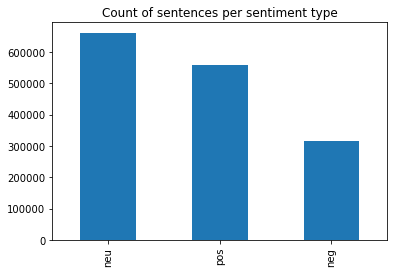

In [ ]:
Post_sent_df['comp_score'].value_counts().plot(kind = 'bar', title = 'Count of sentences per sentiment type')

In [ ]:
# to sum sentiment per dominant topic 
Post_sent_df_grp_sen = Post_sent_df.groupby('Topic', as_index=False)['compoundSco'].mean()

<AxesSubplot:xlabel='Topic'>

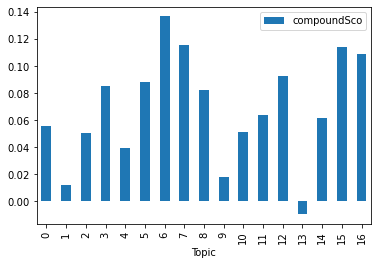

In [ ]:
Post_sent_df_grp_sen.plot(x='Topic', y='compoundSco', kind = 'bar')